In [68]:
# Libs to catch and treat data:
import tweepy           
import pandas as pd    
import numpy as np      
import collections
import re
from os import listdir, mkdir, utime
from os.path import isfile, join, exists
import os
from textblob import TextBlob

# Libs for plotting and visualization:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# getting access keys saved at credentials.py:
from credentials import *

In [69]:
# API Setup
def twitter_setup():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api

In [96]:
api = twitter_setup()
tweets = tweepy.models.ResultSet()
twitter_profile = '@who'

for i in range(6):
    tweets += api.user_timeline(screen_name=twitter_profile, count=200, page=i)
print(f'Tweets obtained: {len(tweets)}.')

#tweets = api.user_timeline(screen_name='@jairbolsonaro', count=200)

print('The first 5 tweets:')
for tweet in tweets[:5]:
    print(tweet.text)
    print()

Tweets obtained: 1200.
The first 5 tweets:
WHO declared #COVID19 a Public Health Emergency of International Concern on 30 January 2020, when there were less t… https://t.co/OkJ1hmSV1Z

#OpenWHO, the free, open-access learning platform for health emergencies, now offers 9 online courses related to… https://t.co/E9OUA9vWxX

@palkisu @DrTedros .@palkisu we don't see you online. If you join, we will take your question. 
https://t.co/ZTkjLQ4iKo

"We’re all in this together. And we will only get through it together"-@DrTedros #COVID19 

The full statement: https://t.co/tLkdaJm0Q3

"Earlier today I spoke to health ministers from across the Eastern Mediterranean region.

I assured them that we wi… https://t.co/gko24hSFJp



In [97]:
df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
display(df.head())

,Tweets
0,WHO declared #COVID19 a Public Health Emergenc...
1,"#OpenWHO, the free, open-access learning platf..."
2,@palkisu @DrTedros .@palkisu we don't see you ...
3,"""We’re all in this together. And we will only ..."
4,"""Earlier today I spoke to health ministers fro..."


### Let's take a look at the internal methods and variables available.

In [98]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


### From here we can select some relevant variables like: id, created_at, source, favorite_count, retweet_count

In [99]:
print(tweets[0].place)

None


In [100]:
df['Size'] = np.array([len(tweet.text) for tweet in tweets])
df['Id'] = np.array([tweet.id for tweet in tweets])
df['Created at'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])

In [107]:
df.head(15)

,Tweets,Size,Id,Created at,Source,Likes,Retweets
0,WHO declared #COVID19 a Public Health Emergenc...,140,1253034861033656320,2020-04-22 18:56:05,Twitter for iPhone,4382,1599
1,"#OpenWHO, the free, open-access learning platf...",137,1253015865991233537,2020-04-22 17:40:37,Twitter Web App,435,234
2,@palkisu @DrTedros .@palkisu we don't see you ...,119,1253004000133251077,2020-04-22 16:53:27,Twitter Web App,8,0
3,"""We’re all in this together. And we will only ...",135,1252995545175592962,2020-04-22 16:19:52,Twitter Web App,300,141
4,"""Earlier today I spoke to health ministers fro...",140,1252994984564981760,2020-04-22 16:17:38,Twitter Web App,183,58
5,"""With the holy month of #Ramadan starting tomo...",140,1252994724639789059,2020-04-22 16:16:36,Twitter Web App,467,162
6,"""We need to ensure these products reach those ...",140,1252994317049827329,2020-04-22 16:14:59,Twitter Web App,120,49
7,"""We also issued a call with the @wto, calling ...",139,1252994229661466625,2020-04-22 16:14:38,Twitter Web App,99,46
8,"""We’re calling on all telecommunications compa...",140,1252994018083995651,2020-04-22 16:13:48,Twitter Web App,84,48
9,"""This will help reach half of the 🌍's populati...",140,1252994016381218816,2020-04-22 16:13:47,Twitter Web App,71,42


### Now let's analyze some statistics and basic information like mean size of tweets, tweets with more likes and tweets with more retweets.

In [108]:
mean_size = np.mean(df['Size'])

most_liked = np.max(df['Likes'])
most_retweeted = np.max(df['Retweets'])

most_liked_index = df[df.Likes == most_liked].index[0]
most_retweeted_index = df[df.Retweets == most_retweeted].index[0]


print(f'Tweet with more Likes:\n{df["Tweets"][most_liked_index]}')
print(f'Qtd. Likes: {most_liked}')
print(f'Qtd. Characters: {df["Size"][most_liked_index]}\n')

print(f'Tweet with more Retweets:\n{df["Tweets"][most_retweeted_index]}')
print(f'Qtd. Likes: {most_retweeted}')
print(f'Qtd. Characters: {df["Size"][most_retweeted_index]}')

Tweet with more Likes:
Stay connected.

Stay fit.

Stay safe.

Stay #HealthyAtHome!
Qtd. Likes: 32168
Qtd. Characters: 60

Tweet with more Retweets:
Stay connected.

Stay fit.

Stay safe.

Stay #HealthyAtHome!
Qtd. Likes: 9013
Qtd. Characters: 60


### Let's take a look at the time series in relation to the size of tweets, likes and retweets.

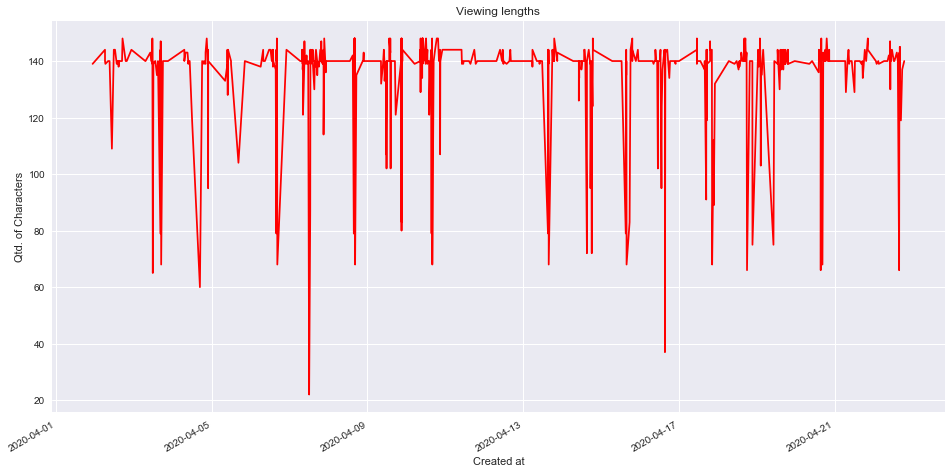

In [127]:
ts_size = pd.Series(data=df['Size'].values, index=df['Created at'])
ts_likes = pd.Series(data=df['Likes'].values, index=df['Created at'])
ts_retweets = pd.Series(data=df['Retweets'].values, index=df['Created at'])

fig = plt.figure(figsize=(16, 8))
ts_size.plot(color='r')
plt.xlabel('Created at')
plt.ylabel('Qtd. of Characters')
plt.title('Viewing lengths')
fig.savefig('img\char_view.png')
plt.show()

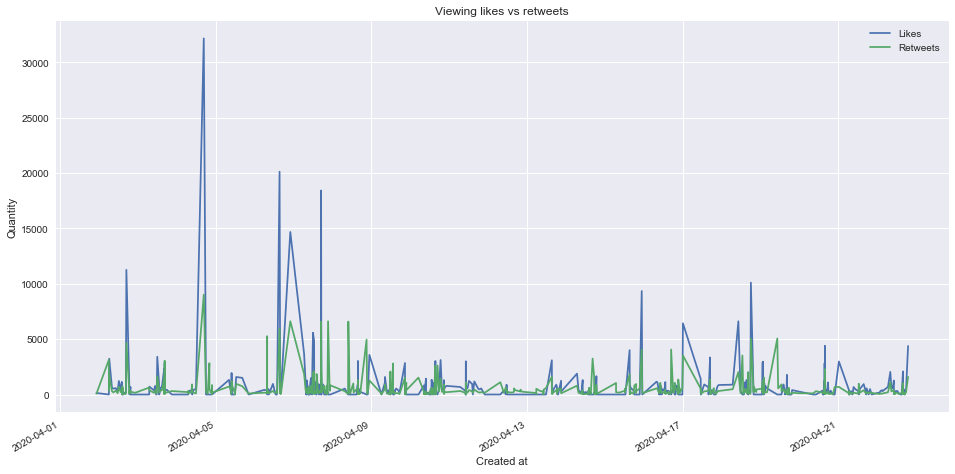

In [128]:
fig = plt.figure(figsize=(16, 8))
ts_likes.plot(label="Likes", legend=True)
ts_retweets.plot(label="Retweets", legend=True);
plt.xlabel('Created at')
plt.ylabel('Quantity')
plt.title('Viewing likes vs retweets')
fig.savefig('img\likes_re_view.png')
plt.show()

### Now let's take a look at the types of sources of tweets.

In [109]:
#  Get possible sources:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)

# Print sources:
print("Content creation sources:")
for source in sources:
    print(f'* {source}')

Content creation sources:
* Twitter for iPhone
* Twitter Web App
* Periscope


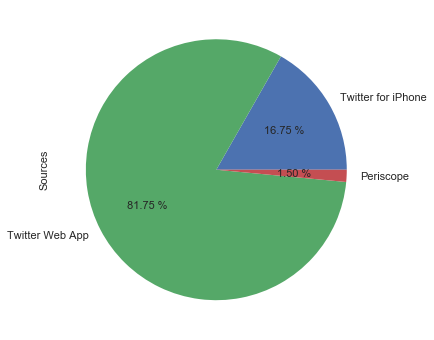

In [110]:
percent = np.zeros(len(sources))

for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
fig = plt.figure()
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f %%', figsize=(6, 6));
fig.savefig('img\sources_view.png')

### Let's vectorize and check the frequency of each word in the set of tweets we are analyzing.

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(df.Tweets)
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,the,1043
1,co,879
2,https,865
3,to,837
4,of,570
5,and,432
6,covid19,407
7,who,361
8,rt,355
9,in,349


### Let's add a few words to the set of Stopwords.

In [113]:
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(['https', 'co', 'rt', 'one', 're', 've', 'will', 'un', 'amp']))

wordcount = collections.defaultdict(int)
for word in stopwords:
    word_count = word_count[word_count.word != word]        

In [114]:
word_count[:60]

,word,count
6,covid19,407
14,drtedros,263
18,countries,165
20,health,140
26,people,104
27,world,103
37,support,83
40,today,76
42,coronavirus,67
43,response,67


### Creating a Word Cloud

<Figure size 1280x640 with 0 Axes>

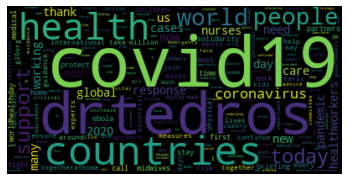

In [115]:
wordcount = collections.defaultdict(int)
wordcount = word_count.set_index('word')['count'].to_dict()
wc = WordCloud().generate_from_frequencies(wordcount)
plt.figure(figsize=(16, 8), dpi=80)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [117]:
text = ''
for word in word_count['word']:
    text += word + ' '
    
    
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
globe_mask = np.array(Image.open("img/globe_mask.png"))
globe_mask = globe_mask[:,:,0]

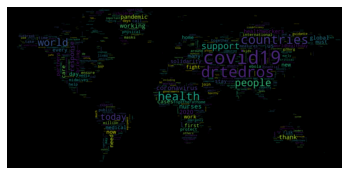

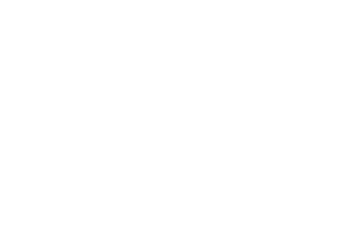

In [119]:
wc = WordCloud(background_color="black", max_words=2000, mask=globe_mask,
               stopwords=stopwords, contour_width=3, contour_color='black')

# generate word cloud
wc.generate_from_frequencies(wordcount)
# store to file
wc.to_file(path.join("img/brainstorm.png"))

# show
#plt.figure(figsize=(25, 8), dpi=300)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(brazil_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Here we clear the tweets and perform sentiment analysis of each one.

In [120]:
def tweet_cleaner(tweet):
    '''
    Function to clean the text of a tweet by removing
    links and special characters using regex.
    '''
    #return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", tweet).split())

    
def sentiment_analysis(tweet):
    '''
    Function to classify the sentiment of the tweet using textblob
    '''
    #print(tweet)
    print('')
    analysis = TextBlob(tweet_cleaner(tweet))
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [121]:
# Create an analysis results column:
df['Sentiment Rank'] = np.array([sentiment_analysis(tweet) for tweet in df['Tweets']])

df.head(10)

,Tweets,Size,Id,Created at,Source,Likes,Retweets,Sentiment Rank
0,WHO declared #COVID19 a Public Health Emergenc...,140,1253034861033656320,2020-04-22 18:56:05,Twitter for iPhone,4382,1599,-1
1,"#OpenWHO, the free, open-access learning platf...",137,1253015865991233537,2020-04-22 17:40:37,Twitter Web App,435,234,1
2,@palkisu @DrTedros .@palkisu we don't see you ...,119,1253004000133251077,2020-04-22 16:53:27,Twitter Web App,8,0,0
3,"""We’re all in this together. And we will only ...",135,1252995545175592962,2020-04-22 16:19:52,Twitter Web App,300,141,1
4,"""Earlier today I spoke to health ministers fro...",140,1252994984564981760,2020-04-22 16:17:38,Twitter Web App,183,58,0
5,"""With the holy month of #Ramadan starting tomo...",140,1252994724639789059,2020-04-22 16:16:36,Twitter Web App,467,162,0
6,"""We need to ensure these products reach those ...",140,1252994317049827329,2020-04-22 16:14:59,Twitter Web App,120,49,1
7,"""We also issued a call with the @wto, calling ...",139,1252994229661466625,2020-04-22 16:14:38,Twitter Web App,99,46,1
8,"""We’re calling on all telecommunications compa...",140,1252994018083995651,2020-04-22 16:13:48,Twitter Web App,84,48,0
9,"""This will help reach half of the 🌍's populati...",140,1252994016381218816,2020-04-22 16:13:47,Twitter Web App,71,42,-1


In [122]:
tweets_positive = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] > 0]
tweets_neutral   = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] == 0]
tweets_negative = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] < 0]

## Results

In [129]:
print(f'Positive tweets: {len(tweets_positive)*100/len(df["Tweets"]):.2f}%')
print(f'Neutral tweets: {len(tweets_neutral)*100/len(df["Tweets"]):.2f}%')
print(f'Negative tweets: {len(tweets_negative)*100/len(df["Tweets"]):.2f}%')

Positive tweets: 44.08%
Neutral tweets: 41.75%
Negative tweets: 14.17%
